# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.33KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

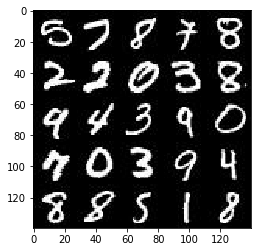

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

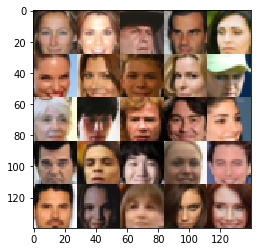

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function - DONE
    input_image=tf.placeholder(tf.float32,[None,image_width,image_height,image_channels],name="input_real")
    Z_input=tf.placeholder(tf.float32,[None,z_dim],name="input_z")
    learning_rate=tf.placeholder(tf.float32,name="learning_rate")

    return (input_image,Z_input,learning_rate)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function - DONE

    with tf.variable_scope("discriminator", reuse = reuse):
        alpha=0.2
        layer1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        norm1 = tf.layers.batch_normalization(layer1, training=True)
        relu1 = tf.maximum(alpha * norm1, norm1)
        #16x16x128
        
        layer2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        norm2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(alpha * norm2, norm2)
        #8x8x256
        
        layer3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        norm3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha * norm3, norm3)
        #4x4x512

        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #Implement Function - DONE
    
    reuse = not is_train
    alpha=0.1
    with tf.variable_scope('generator', reuse = reuse):
        #Fully connected layer
        layer1 = tf.layers.dense(z,  7 * 7 * 512)
        #Reshape the fully connected layer to start the convolutional stack
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1 = tf.layers.batch_normalization(layer1, training = is_train)
        layer1 = tf.maximum(alpha*layer1, layer1)
        # 7x7x512 now
        
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides = 2, padding = 'same')
        layer2 = tf.layers.batch_normalization(layer2, training = is_train)
        layer2 = tf.maximum(alpha*layer2, layer2)
        # 14x14x256 now
        
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training = is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function - DONE
    
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,labels = tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    #Implement Function - DONE
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #Optimize
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list=d_vars)
    
    # Tell TensorFlow to update the population statistics while training
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    steps = 0
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    is_train = tf.placeholder(tf.bool)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                 # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate,is_train:True})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate,is_train:False})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    #Print the current image
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7534... Generator Loss: 1.4197
Epoch 1/2... Discriminator Loss: 1.3965... Generator Loss: 0.5335
Epoch 1/2... Discriminator Loss: 2.6764... Generator Loss: 0.2473
Epoch 1/2... Discriminator Loss: 2.6424... Generator Loss: 0.1854
Epoch 1/2... Discriminator Loss: 2.4474... Generator Loss: 0.2158
Epoch 1/2... Discriminator Loss: 2.5161... Generator Loss: 0.2246
Epoch 1/2... Discriminator Loss: 2.4498... Generator Loss: 0.2382
Epoch 1/2... Discriminator Loss: 2.1294... Generator Loss: 0.3693
Epoch 1/2... Discriminator Loss: 1.9159... Generator Loss: 0.5463
Epoch 1/2... Discriminator Loss: 1.8238... Generator Loss: 0.5451


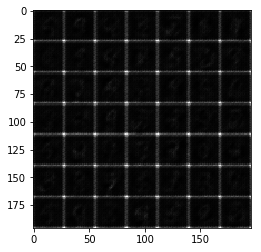

Epoch 1/2... Discriminator Loss: 1.9683... Generator Loss: 0.2838
Epoch 1/2... Discriminator Loss: 1.6777... Generator Loss: 0.8529
Epoch 1/2... Discriminator Loss: 1.6027... Generator Loss: 0.8119
Epoch 1/2... Discriminator Loss: 1.6013... Generator Loss: 0.4477
Epoch 1/2... Discriminator Loss: 1.5312... Generator Loss: 0.5979
Epoch 1/2... Discriminator Loss: 1.7396... Generator Loss: 0.3471
Epoch 1/2... Discriminator Loss: 1.4737... Generator Loss: 1.1017
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 0.7990
Epoch 1/2... Discriminator Loss: 1.5266... Generator Loss: 0.5984
Epoch 1/2... Discriminator Loss: 1.5062... Generator Loss: 1.1180


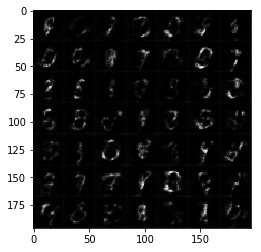

Epoch 1/2... Discriminator Loss: 1.3431... Generator Loss: 0.8521
Epoch 1/2... Discriminator Loss: 1.4489... Generator Loss: 0.5049
Epoch 1/2... Discriminator Loss: 1.5842... Generator Loss: 0.4197
Epoch 1/2... Discriminator Loss: 1.4256... Generator Loss: 1.6448
Epoch 1/2... Discriminator Loss: 1.4890... Generator Loss: 0.5602
Epoch 1/2... Discriminator Loss: 1.6578... Generator Loss: 0.4340
Epoch 1/2... Discriminator Loss: 1.5713... Generator Loss: 1.3044
Epoch 1/2... Discriminator Loss: 1.4912... Generator Loss: 0.4866
Epoch 1/2... Discriminator Loss: 1.6358... Generator Loss: 0.6431
Epoch 1/2... Discriminator Loss: 1.6379... Generator Loss: 0.4642


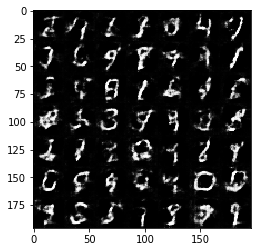

Epoch 1/2... Discriminator Loss: 1.6161... Generator Loss: 0.4833
Epoch 1/2... Discriminator Loss: 1.5621... Generator Loss: 0.6662
Epoch 1/2... Discriminator Loss: 1.6098... Generator Loss: 0.5173
Epoch 1/2... Discriminator Loss: 1.6627... Generator Loss: 0.6468
Epoch 1/2... Discriminator Loss: 1.5231... Generator Loss: 0.5652
Epoch 1/2... Discriminator Loss: 1.5513... Generator Loss: 0.6351
Epoch 1/2... Discriminator Loss: 1.5226... Generator Loss: 0.6322
Epoch 1/2... Discriminator Loss: 1.6117... Generator Loss: 0.8671
Epoch 1/2... Discriminator Loss: 1.6495... Generator Loss: 0.4340
Epoch 1/2... Discriminator Loss: 1.8196... Generator Loss: 0.3129


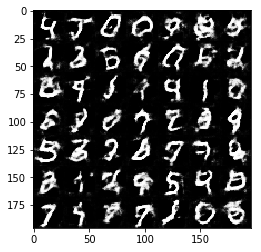

Epoch 1/2... Discriminator Loss: 1.6239... Generator Loss: 0.6152
Epoch 1/2... Discriminator Loss: 1.5999... Generator Loss: 0.7533
Epoch 1/2... Discriminator Loss: 1.7007... Generator Loss: 0.4218
Epoch 1/2... Discriminator Loss: 1.6565... Generator Loss: 0.4027
Epoch 1/2... Discriminator Loss: 1.5345... Generator Loss: 0.7169
Epoch 1/2... Discriminator Loss: 1.4691... Generator Loss: 0.7891
Epoch 1/2... Discriminator Loss: 1.4698... Generator Loss: 0.7841
Epoch 1/2... Discriminator Loss: 1.5444... Generator Loss: 0.6189
Epoch 1/2... Discriminator Loss: 1.5364... Generator Loss: 0.4651
Epoch 1/2... Discriminator Loss: 1.5045... Generator Loss: 0.5882


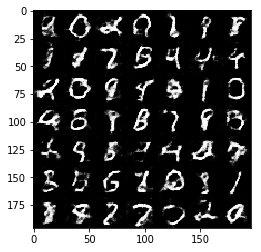

Epoch 1/2... Discriminator Loss: 1.4708... Generator Loss: 0.6732
Epoch 1/2... Discriminator Loss: 1.6767... Generator Loss: 0.3936
Epoch 1/2... Discriminator Loss: 1.7698... Generator Loss: 0.3465
Epoch 1/2... Discriminator Loss: 1.4916... Generator Loss: 0.7350
Epoch 1/2... Discriminator Loss: 1.6420... Generator Loss: 0.3808
Epoch 1/2... Discriminator Loss: 1.6631... Generator Loss: 0.3936
Epoch 1/2... Discriminator Loss: 1.3373... Generator Loss: 0.7963
Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 0.7261
Epoch 1/2... Discriminator Loss: 1.4824... Generator Loss: 0.6588
Epoch 1/2... Discriminator Loss: 1.6132... Generator Loss: 0.4655


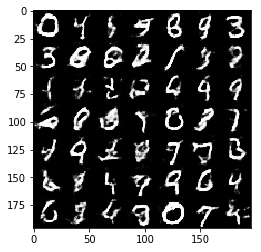

Epoch 1/2... Discriminator Loss: 1.5868... Generator Loss: 0.5849
Epoch 1/2... Discriminator Loss: 1.5736... Generator Loss: 0.5073
Epoch 1/2... Discriminator Loss: 1.4606... Generator Loss: 0.8514
Epoch 1/2... Discriminator Loss: 1.5996... Generator Loss: 0.4384
Epoch 1/2... Discriminator Loss: 1.5792... Generator Loss: 0.6235
Epoch 1/2... Discriminator Loss: 1.5289... Generator Loss: 0.6598
Epoch 1/2... Discriminator Loss: 1.5796... Generator Loss: 0.4387
Epoch 1/2... Discriminator Loss: 1.5176... Generator Loss: 0.6431
Epoch 1/2... Discriminator Loss: 1.4598... Generator Loss: 0.7560
Epoch 1/2... Discriminator Loss: 1.5378... Generator Loss: 0.4696


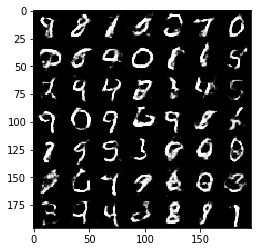

Epoch 1/2... Discriminator Loss: 1.5707... Generator Loss: 0.6959
Epoch 1/2... Discriminator Loss: 1.5159... Generator Loss: 0.9112
Epoch 1/2... Discriminator Loss: 1.4961... Generator Loss: 0.5370
Epoch 1/2... Discriminator Loss: 1.5250... Generator Loss: 0.5673
Epoch 1/2... Discriminator Loss: 1.4206... Generator Loss: 0.7901
Epoch 1/2... Discriminator Loss: 1.5363... Generator Loss: 0.7689
Epoch 1/2... Discriminator Loss: 1.5779... Generator Loss: 0.8129
Epoch 1/2... Discriminator Loss: 1.5744... Generator Loss: 0.6850
Epoch 1/2... Discriminator Loss: 1.5047... Generator Loss: 0.6114
Epoch 1/2... Discriminator Loss: 1.4853... Generator Loss: 0.5872


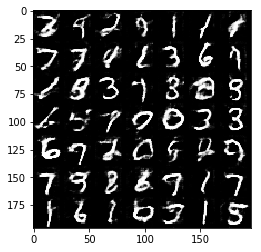

Epoch 1/2... Discriminator Loss: 1.6025... Generator Loss: 0.4489
Epoch 1/2... Discriminator Loss: 1.5666... Generator Loss: 0.6922
Epoch 1/2... Discriminator Loss: 1.5188... Generator Loss: 0.4966
Epoch 1/2... Discriminator Loss: 1.5029... Generator Loss: 0.6158
Epoch 1/2... Discriminator Loss: 1.5091... Generator Loss: 0.7399
Epoch 1/2... Discriminator Loss: 1.4369... Generator Loss: 0.7843
Epoch 1/2... Discriminator Loss: 1.4371... Generator Loss: 0.8518
Epoch 1/2... Discriminator Loss: 1.4834... Generator Loss: 0.6821
Epoch 1/2... Discriminator Loss: 1.5495... Generator Loss: 0.5205
Epoch 1/2... Discriminator Loss: 1.5734... Generator Loss: 0.4769


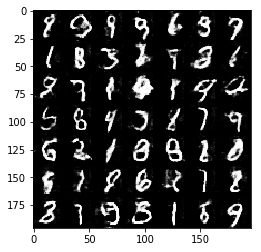

Epoch 1/2... Discriminator Loss: 1.6547... Generator Loss: 0.3674
Epoch 1/2... Discriminator Loss: 1.4742... Generator Loss: 0.6729
Epoch 1/2... Discriminator Loss: 1.4830... Generator Loss: 0.5722
Epoch 2/2... Discriminator Loss: 1.5219... Generator Loss: 0.6174
Epoch 2/2... Discriminator Loss: 1.7481... Generator Loss: 0.3448
Epoch 2/2... Discriminator Loss: 1.6627... Generator Loss: 0.4476
Epoch 2/2... Discriminator Loss: 1.7096... Generator Loss: 0.9768
Epoch 2/2... Discriminator Loss: 1.5600... Generator Loss: 0.5897
Epoch 2/2... Discriminator Loss: 1.5028... Generator Loss: 0.9347
Epoch 2/2... Discriminator Loss: 1.4607... Generator Loss: 0.9932


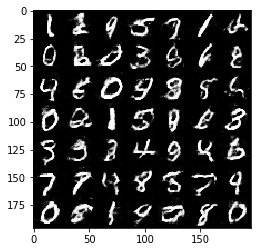

Epoch 2/2... Discriminator Loss: 1.6067... Generator Loss: 0.4787
Epoch 2/2... Discriminator Loss: 1.5880... Generator Loss: 0.5464
Epoch 2/2... Discriminator Loss: 1.6883... Generator Loss: 0.3813
Epoch 2/2... Discriminator Loss: 1.5130... Generator Loss: 0.8956
Epoch 2/2... Discriminator Loss: 1.4474... Generator Loss: 1.0177
Epoch 2/2... Discriminator Loss: 1.5962... Generator Loss: 0.4638
Epoch 2/2... Discriminator Loss: 1.6515... Generator Loss: 0.4135
Epoch 2/2... Discriminator Loss: 1.4899... Generator Loss: 0.7626
Epoch 2/2... Discriminator Loss: 1.5903... Generator Loss: 0.4845
Epoch 2/2... Discriminator Loss: 1.6972... Generator Loss: 0.4149


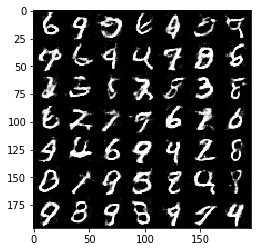

Epoch 2/2... Discriminator Loss: 1.5516... Generator Loss: 0.6203
Epoch 2/2... Discriminator Loss: 1.5327... Generator Loss: 0.5973
Epoch 2/2... Discriminator Loss: 1.4513... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 1.6922... Generator Loss: 0.3781
Epoch 2/2... Discriminator Loss: 1.5761... Generator Loss: 0.4959
Epoch 2/2... Discriminator Loss: 1.5208... Generator Loss: 0.6916
Epoch 2/2... Discriminator Loss: 1.5651... Generator Loss: 0.5282
Epoch 2/2... Discriminator Loss: 1.5373... Generator Loss: 0.5498
Epoch 2/2... Discriminator Loss: 1.6137... Generator Loss: 0.4018
Epoch 2/2... Discriminator Loss: 1.6775... Generator Loss: 0.4029


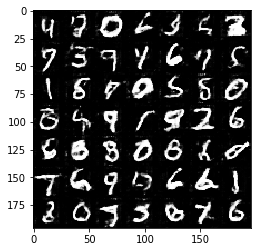

Epoch 2/2... Discriminator Loss: 1.6149... Generator Loss: 0.4197
Epoch 2/2... Discriminator Loss: 1.5240... Generator Loss: 0.5408
Epoch 2/2... Discriminator Loss: 1.5807... Generator Loss: 0.4591
Epoch 2/2... Discriminator Loss: 1.6193... Generator Loss: 0.4648
Epoch 2/2... Discriminator Loss: 1.5029... Generator Loss: 0.8897
Epoch 2/2... Discriminator Loss: 1.6775... Generator Loss: 0.4589
Epoch 2/2... Discriminator Loss: 1.4320... Generator Loss: 0.6919
Epoch 2/2... Discriminator Loss: 1.6575... Generator Loss: 0.4142
Epoch 2/2... Discriminator Loss: 1.4912... Generator Loss: 0.5851
Epoch 2/2... Discriminator Loss: 1.6954... Generator Loss: 0.4007


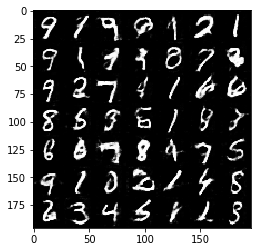

Epoch 2/2... Discriminator Loss: 1.6090... Generator Loss: 0.5186
Epoch 2/2... Discriminator Loss: 1.5258... Generator Loss: 0.4685
Epoch 2/2... Discriminator Loss: 1.5184... Generator Loss: 0.5846
Epoch 2/2... Discriminator Loss: 1.5484... Generator Loss: 0.5937
Epoch 2/2... Discriminator Loss: 1.5418... Generator Loss: 0.5209
Epoch 2/2... Discriminator Loss: 1.4263... Generator Loss: 0.8647
Epoch 2/2... Discriminator Loss: 1.7376... Generator Loss: 0.3565
Epoch 2/2... Discriminator Loss: 1.5275... Generator Loss: 0.9374
Epoch 2/2... Discriminator Loss: 1.5517... Generator Loss: 0.6339
Epoch 2/2... Discriminator Loss: 1.5589... Generator Loss: 0.4932


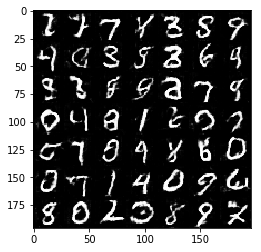

Epoch 2/2... Discriminator Loss: 1.7181... Generator Loss: 0.3722
Epoch 2/2... Discriminator Loss: 1.5220... Generator Loss: 0.5453
Epoch 2/2... Discriminator Loss: 1.5643... Generator Loss: 0.5075
Epoch 2/2... Discriminator Loss: 1.4942... Generator Loss: 0.8169
Epoch 2/2... Discriminator Loss: 1.5972... Generator Loss: 0.4946
Epoch 2/2... Discriminator Loss: 1.5221... Generator Loss: 0.5479
Epoch 2/2... Discriminator Loss: 1.4545... Generator Loss: 0.8837
Epoch 2/2... Discriminator Loss: 1.6800... Generator Loss: 0.3624
Epoch 2/2... Discriminator Loss: 1.5455... Generator Loss: 0.8168
Epoch 2/2... Discriminator Loss: 1.7162... Generator Loss: 0.3756


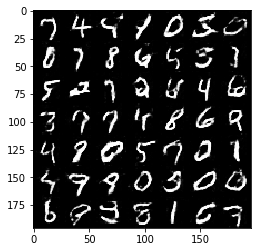

Epoch 2/2... Discriminator Loss: 1.5298... Generator Loss: 0.5554
Epoch 2/2... Discriminator Loss: 1.4934... Generator Loss: 0.9586
Epoch 2/2... Discriminator Loss: 1.4945... Generator Loss: 0.6651
Epoch 2/2... Discriminator Loss: 1.4810... Generator Loss: 0.5754
Epoch 2/2... Discriminator Loss: 1.5420... Generator Loss: 0.4749
Epoch 2/2... Discriminator Loss: 1.5066... Generator Loss: 1.0036
Epoch 2/2... Discriminator Loss: 1.4286... Generator Loss: 0.7771
Epoch 2/2... Discriminator Loss: 1.5123... Generator Loss: 0.8795
Epoch 2/2... Discriminator Loss: 1.5230... Generator Loss: 0.7334
Epoch 2/2... Discriminator Loss: 1.6023... Generator Loss: 0.4570


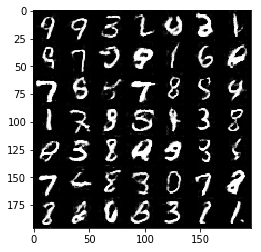

Epoch 2/2... Discriminator Loss: 1.4763... Generator Loss: 0.7095
Epoch 2/2... Discriminator Loss: 1.6493... Generator Loss: 0.4072
Epoch 2/2... Discriminator Loss: 1.6021... Generator Loss: 0.4834
Epoch 2/2... Discriminator Loss: 1.5300... Generator Loss: 0.5851
Epoch 2/2... Discriminator Loss: 1.5838... Generator Loss: 0.8843
Epoch 2/2... Discriminator Loss: 1.5296... Generator Loss: 0.4898
Epoch 2/2... Discriminator Loss: 1.5815... Generator Loss: 0.5325
Epoch 2/2... Discriminator Loss: 1.5318... Generator Loss: 0.4978
Epoch 2/2... Discriminator Loss: 1.4910... Generator Loss: 0.7809
Epoch 2/2... Discriminator Loss: 1.5710... Generator Loss: 0.7893


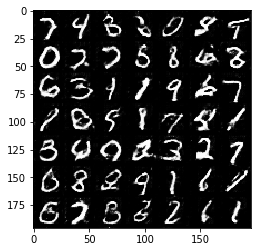

Epoch 2/2... Discriminator Loss: 1.5390... Generator Loss: 0.4523
Epoch 2/2... Discriminator Loss: 1.4809... Generator Loss: 0.6771
Epoch 2/2... Discriminator Loss: 1.4936... Generator Loss: 0.6280
Epoch 2/2... Discriminator Loss: 1.5232... Generator Loss: 0.5398
Epoch 2/2... Discriminator Loss: 1.5599... Generator Loss: 0.4717
Epoch 2/2... Discriminator Loss: 1.4767... Generator Loss: 0.6158
Epoch 2/2... Discriminator Loss: 1.4441... Generator Loss: 0.8295
Epoch 2/2... Discriminator Loss: 1.4965... Generator Loss: 0.5788
Epoch 2/2... Discriminator Loss: 1.5906... Generator Loss: 0.4761
Epoch 2/2... Discriminator Loss: 1.5632... Generator Loss: 0.4737


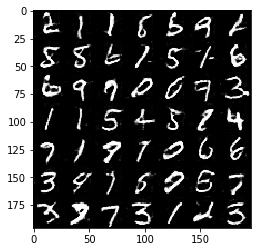

Epoch 2/2... Discriminator Loss: 1.4912... Generator Loss: 0.9378
Epoch 2/2... Discriminator Loss: 1.5409... Generator Loss: 0.5485
Epoch 2/2... Discriminator Loss: 1.5139... Generator Loss: 0.4855
Epoch 2/2... Discriminator Loss: 1.4848... Generator Loss: 0.5572
Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 0.7401
Epoch 2/2... Discriminator Loss: 1.6741... Generator Loss: 0.3910
Epoch 2/2... Discriminator Loss: 1.5456... Generator Loss: 0.4722


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.9736... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 4.9003... Generator Loss: 0.0436
Epoch 1/1... Discriminator Loss: 4.4364... Generator Loss: 0.0359
Epoch 1/1... Discriminator Loss: 2.5314... Generator Loss: 0.2015
Epoch 1/1... Discriminator Loss: 2.8734... Generator Loss: 0.1531
Epoch 1/1... Discriminator Loss: 4.0908... Generator Loss: 0.0413
Epoch 1/1... Discriminator Loss: 3.0402... Generator Loss: 0.1282
Epoch 1/1... Discriminator Loss: 2.7888... Generator Loss: 0.2357
Epoch 1/1... Discriminator Loss: 2.8024... Generator Loss: 0.2814
Epoch 1/1... Discriminator Loss: 1.8101... Generator Loss: 0.6150


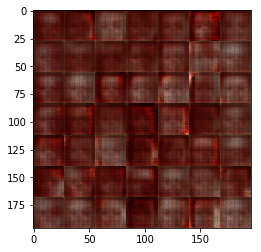

Epoch 1/1... Discriminator Loss: 2.0838... Generator Loss: 0.3196
Epoch 1/1... Discriminator Loss: 1.8716... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 1.8185... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.9393... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.8465... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.8139... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 2.0658... Generator Loss: 0.4527
Epoch 1/1... Discriminator Loss: 1.9618... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.7755... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.5966... Generator Loss: 0.6479


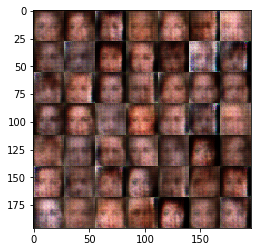

Epoch 1/1... Discriminator Loss: 1.6126... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.6927... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.6785... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.6155... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.6761... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.5765... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.5585... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.7468


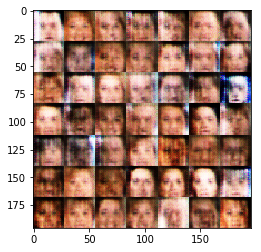

Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.5825... Generator Loss: 0.5291
Epoch 1/1... Discriminator Loss: 1.5675... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.7634... Generator Loss: 0.5073
Epoch 1/1... Discriminator Loss: 1.5995... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.6050... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.6774


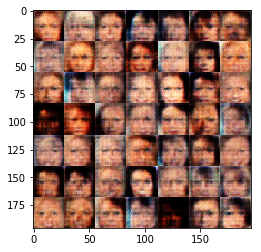

Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.6870... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.6861... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 1.0691


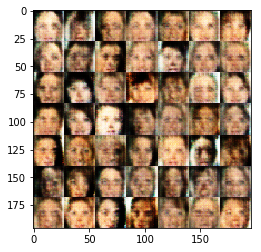

Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.6177... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.5409... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.5916... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.8837


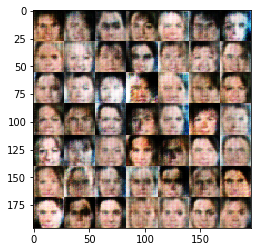

Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.6170... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.8068


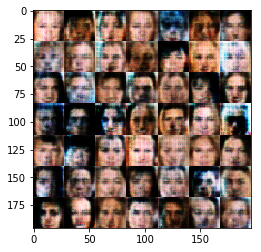

Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.5513... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.6277... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.5624... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.7672... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.6716... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6968


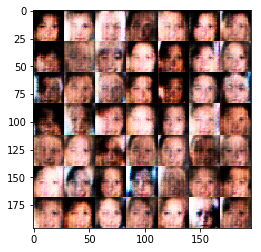

Epoch 1/1... Discriminator Loss: 1.5753... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.6522... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.5598... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.7824


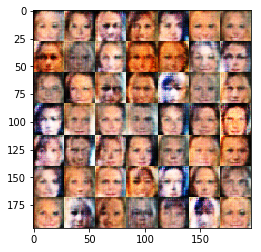

Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.5659... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6934


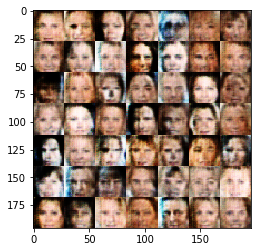

Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.5663... Generator Loss: 1.1146
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7300


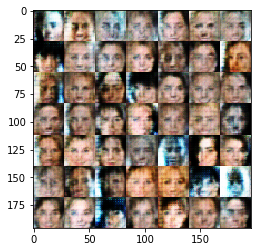

Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.5582... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 0.5687
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.6542


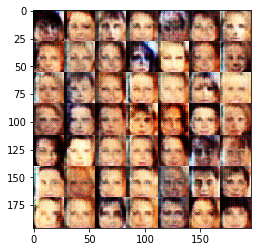

Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.5347... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.6386


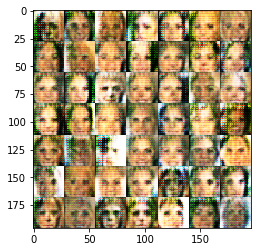

Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.6521... Generator Loss: 1.0894
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.5730... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.7499


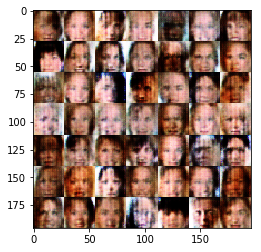

Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.8289


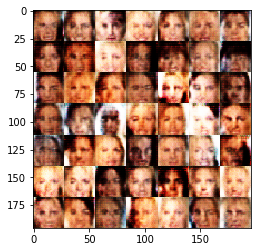

Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.5343... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.5591... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.8760


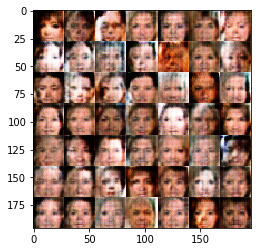

Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.5331... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.6160


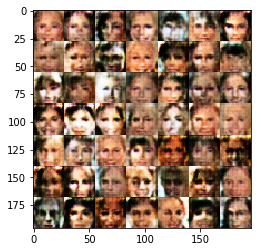

Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.6445


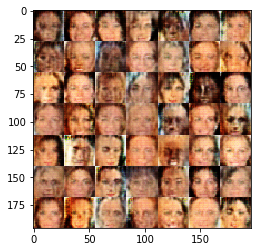

Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.5579


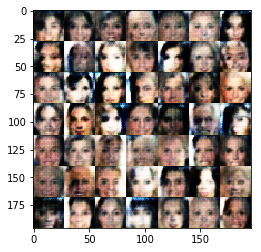

Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 1.0628
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.5887... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.6493


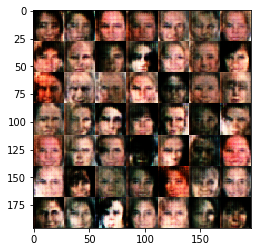

Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.8043


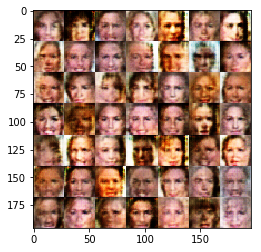

Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.5802... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.6167... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 1.7725... Generator Loss: 0.3511
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.9580


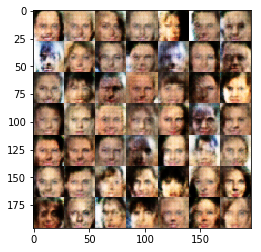

Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7142


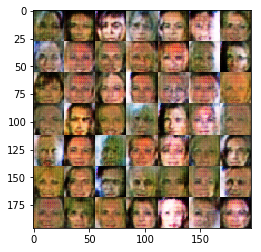

Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 1.1029
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7493


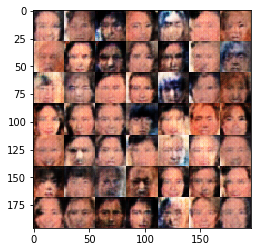

Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7640


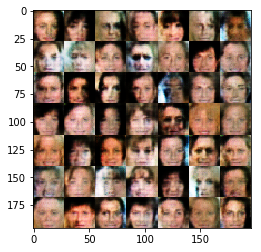

Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 1.1325
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.5880... Generator Loss: 0.4739
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.5964


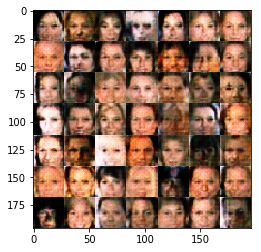

Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.7354


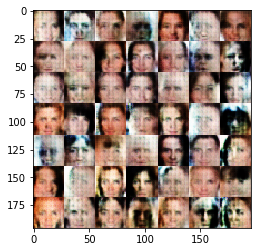

Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.9905
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.6683


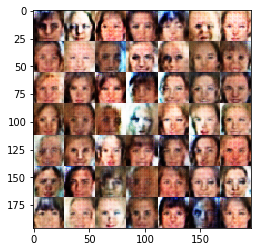

Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7380


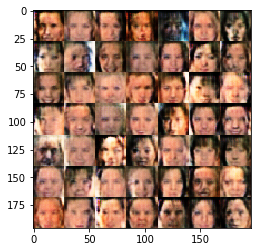

Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 1.1535
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.6675


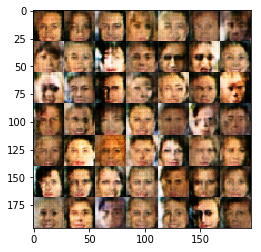

Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.7478


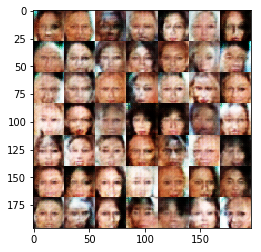

Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.8301


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.